In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

<IPython.core.display.Javascript object>


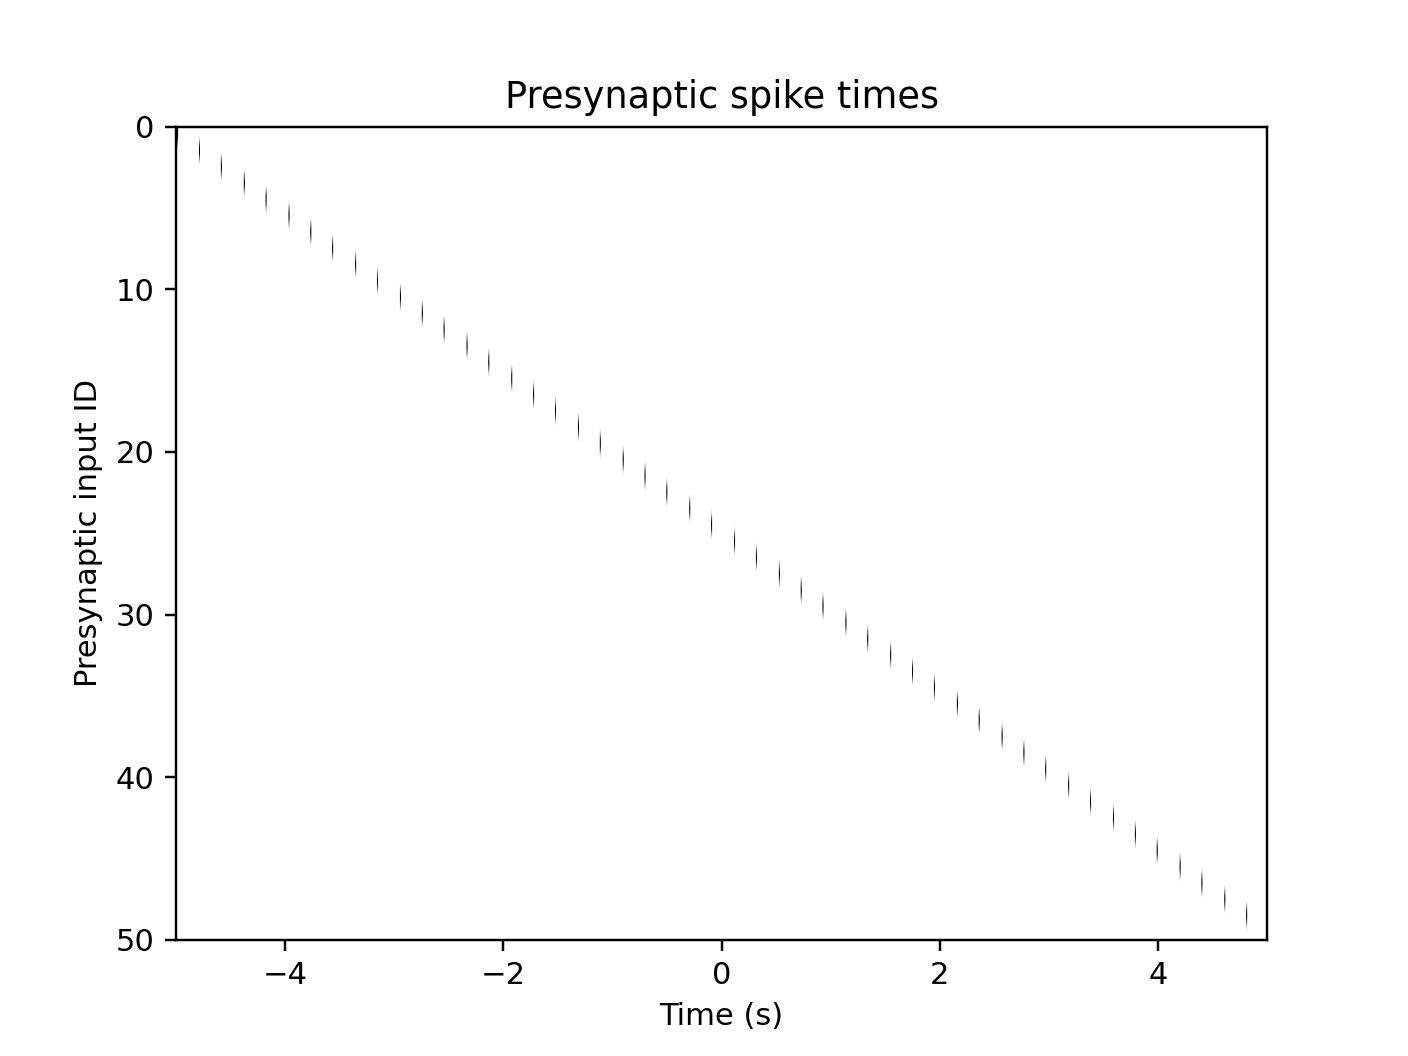

Text(0.5, 1.0, 'Presynaptic spike times')

In [65]:
input_dim = 50
t_res = 0.01
input_locs = np.linspace(-5., 5., input_dim)
t = np.arange(-10., 10., t_res)
pre_activity = np.zeros((input_dim, len(t)))
for i in range(input_dim):
    index = np.where(t >= input_locs[i])[0][0]
    pre_activity[i, index] = 1.
plt.figure()
plt.imshow(pre_activity, aspect='auto', extent=(-10., 10., 50, 0), cmap='binary')
plt.xlim(-5., 5.)
plt.xlabel('Time (s)')
plt.ylabel('Presynaptic input ID')
plt.title('Presynaptic spike times')

<IPython.core.display.Javascript object>


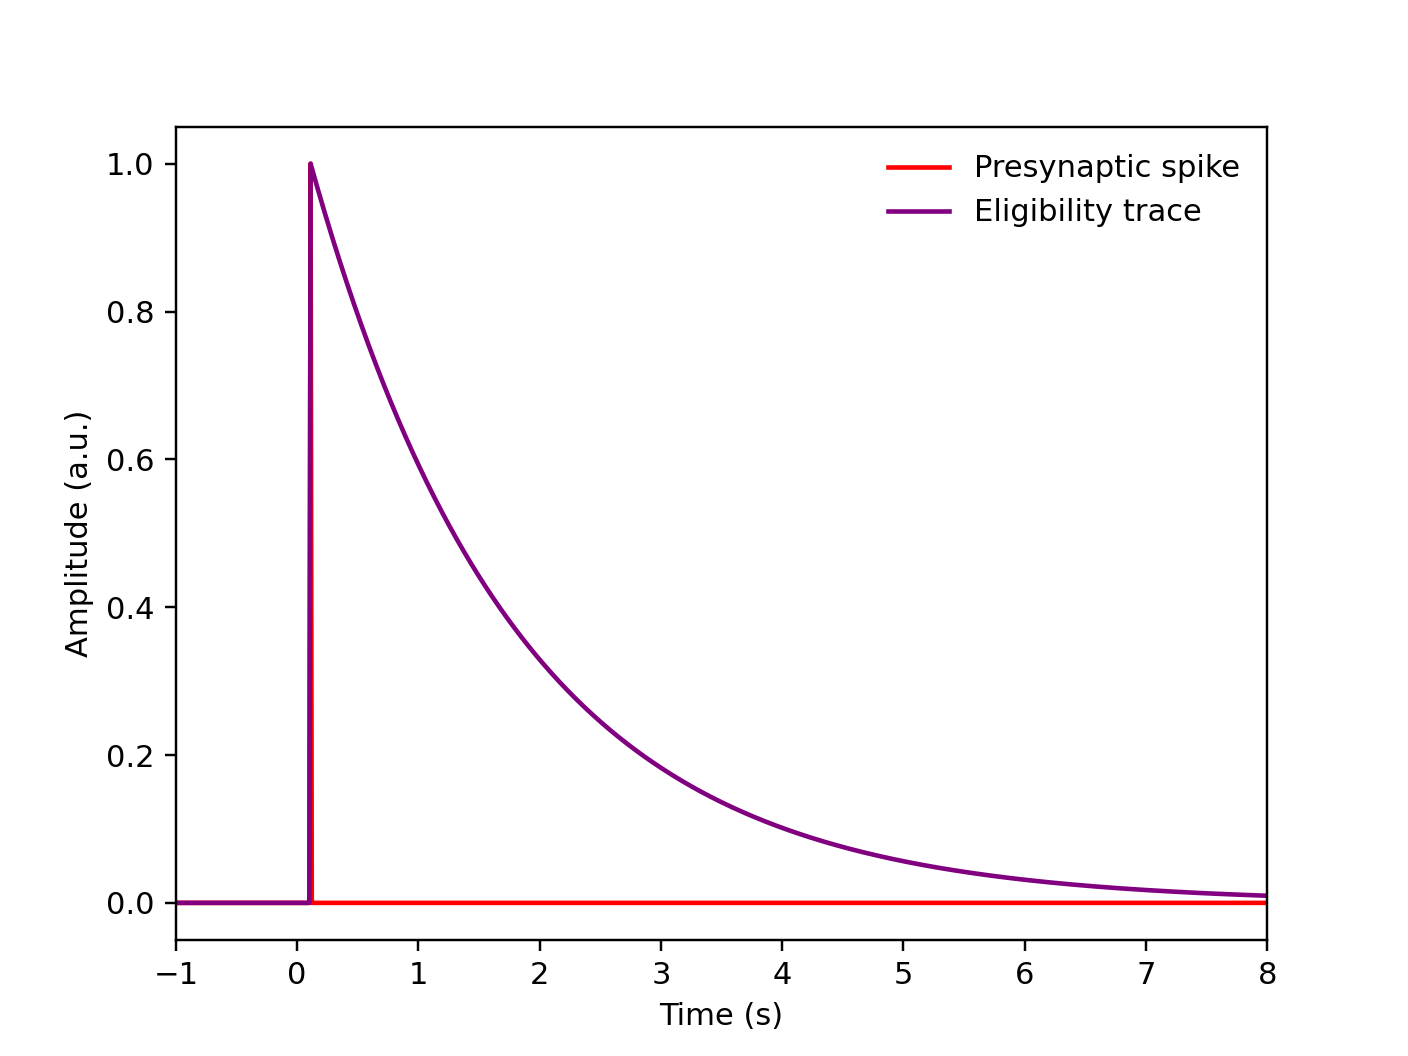

<IPython.core.display.Javascript object>


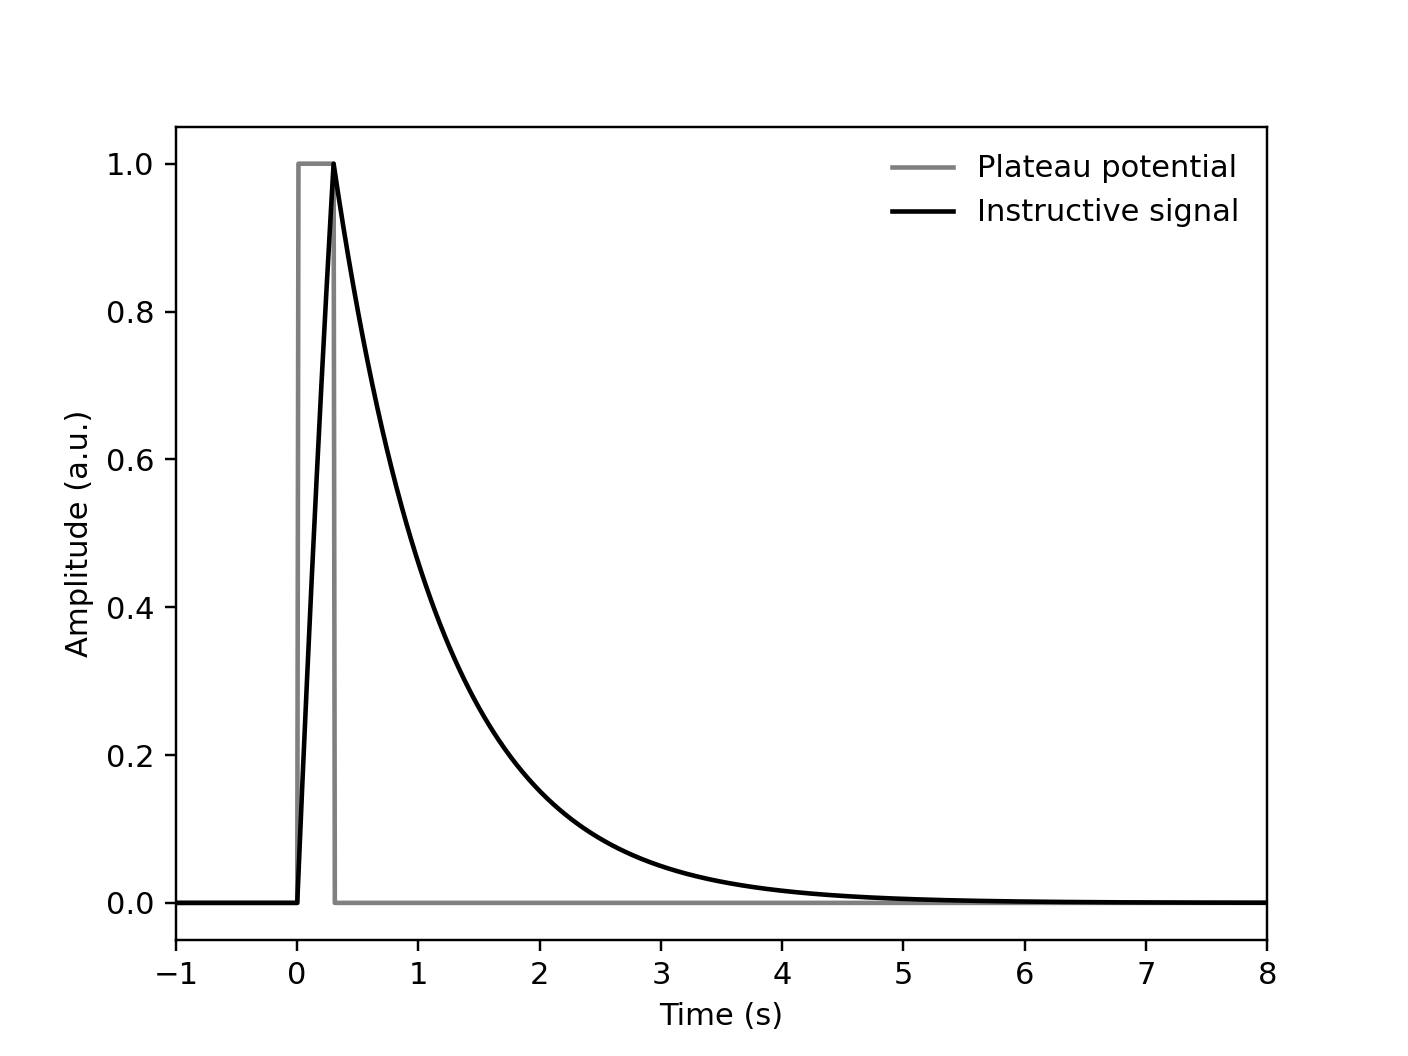

In [72]:
example_input_spike = pre_activity[input_dim//2,:]
plateau = np.zeros_like(t)
plateau_indexes = np.where((t >= 0.) & (t < 0.3))[0]
plateau[plateau_indexes] = 1.
tau_ET = 1.7
tau_IS = 0.9

filter_ET = np.exp(-t/tau_ET)
filter_ET /= np.sum(filter_ET)
this_ET = np.convolve(example_input_spike, filter_ET)[:len(t)]
ET_norm_factor = np.max(this_ET)
this_ET /= ET_norm_factor

filter_IS = np.exp(-t/tau_IS)
filter_IS /= np.sum(filter_IS)
IS = np.convolve(plateau, filter_IS)[:len(t)]
IS /= np.max(IS)

plt.figure()
plt.plot(t, example_input_spike, label='Presynaptic spike', c='r')
plt.plot(t, this_ET, label='Eligibility trace', c='purple')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.xlim((-1., 8.))
plt.legend(loc='best', frameon=False)

plt.figure()
plt.plot(t, plateau, label='Plateau potential', c='grey')
plt.plot(t, IS, label='Instructive signal', c='k')
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time (s)')
plt.xlim((-1., 8.))
plt.legend(loc='best', frameon=False)

<IPython.core.display.Javascript object>


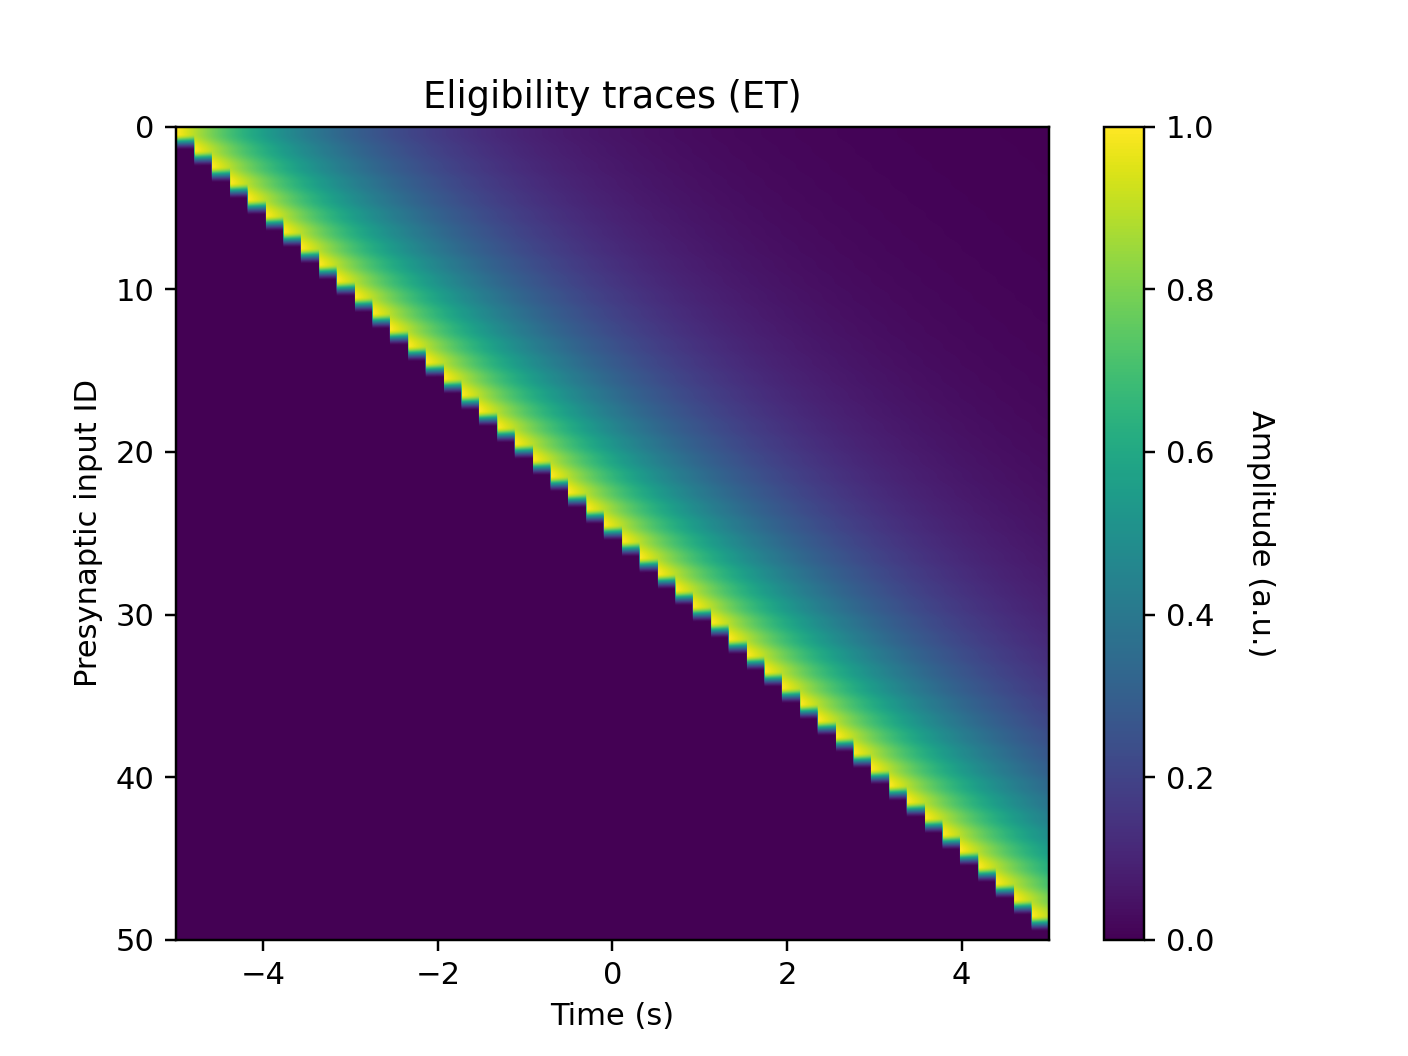

<IPython.core.display.Javascript object>


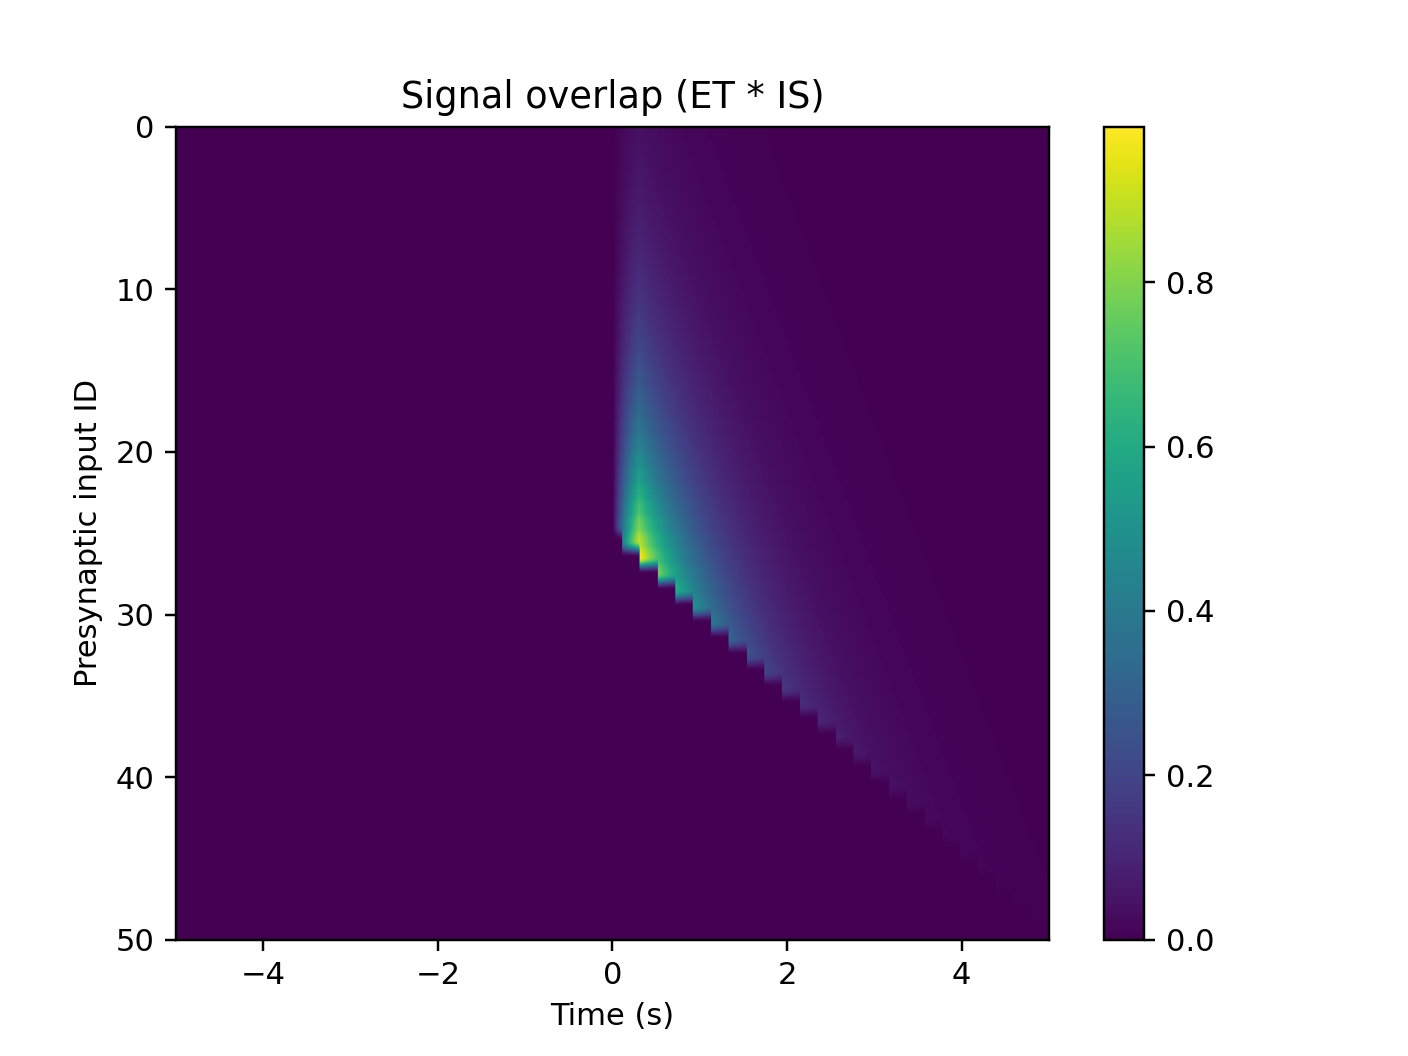

Text(0.5, 1.0, 'Signal overlap (ET * IS)')

In [80]:
ET = np.empty_like(pre_activity)
for i in range(input_dim):
    ET[i,:] = np.convolve(pre_activity[i,:], filter_ET)[:len(t)] / ET_norm_factor
plt.figure()
plt.imshow(ET, aspect='auto', extent=(-10., 10., 50, 0))
cbar = plt.colorbar()
cbar.set_label('Amplitude (a.u.)', rotation=270., labelpad=20)
plt.xlim(-5., 5.)
plt.xlabel('Time (s)')
plt.ylabel('Presynaptic input ID')
plt.title('Eligibility traces (ET)')

ET_IS = ET * IS
plt.figure()
plt.imshow(ET_IS, aspect='auto', extent=(-10., 10., 50, 0))
plt.colorbar()
plt.xlim(-5., 5.)
plt.xlabel('Time (s)')
plt.ylabel('Presynaptic input ID')
plt.title('Signal overlap (ET * IS)')

plt.figure()
plt.imshow(np.concatenateET_IS, aspect='auto', extent=(-10., 10., 50, 0))
plt.colorbar()
plt.xlim(-5., 5.)
plt.xlabel('Time (s)')
plt.ylabel('Presynaptic input ID')
plt.title('Plateau potential')

<IPython.core.display.Javascript object>


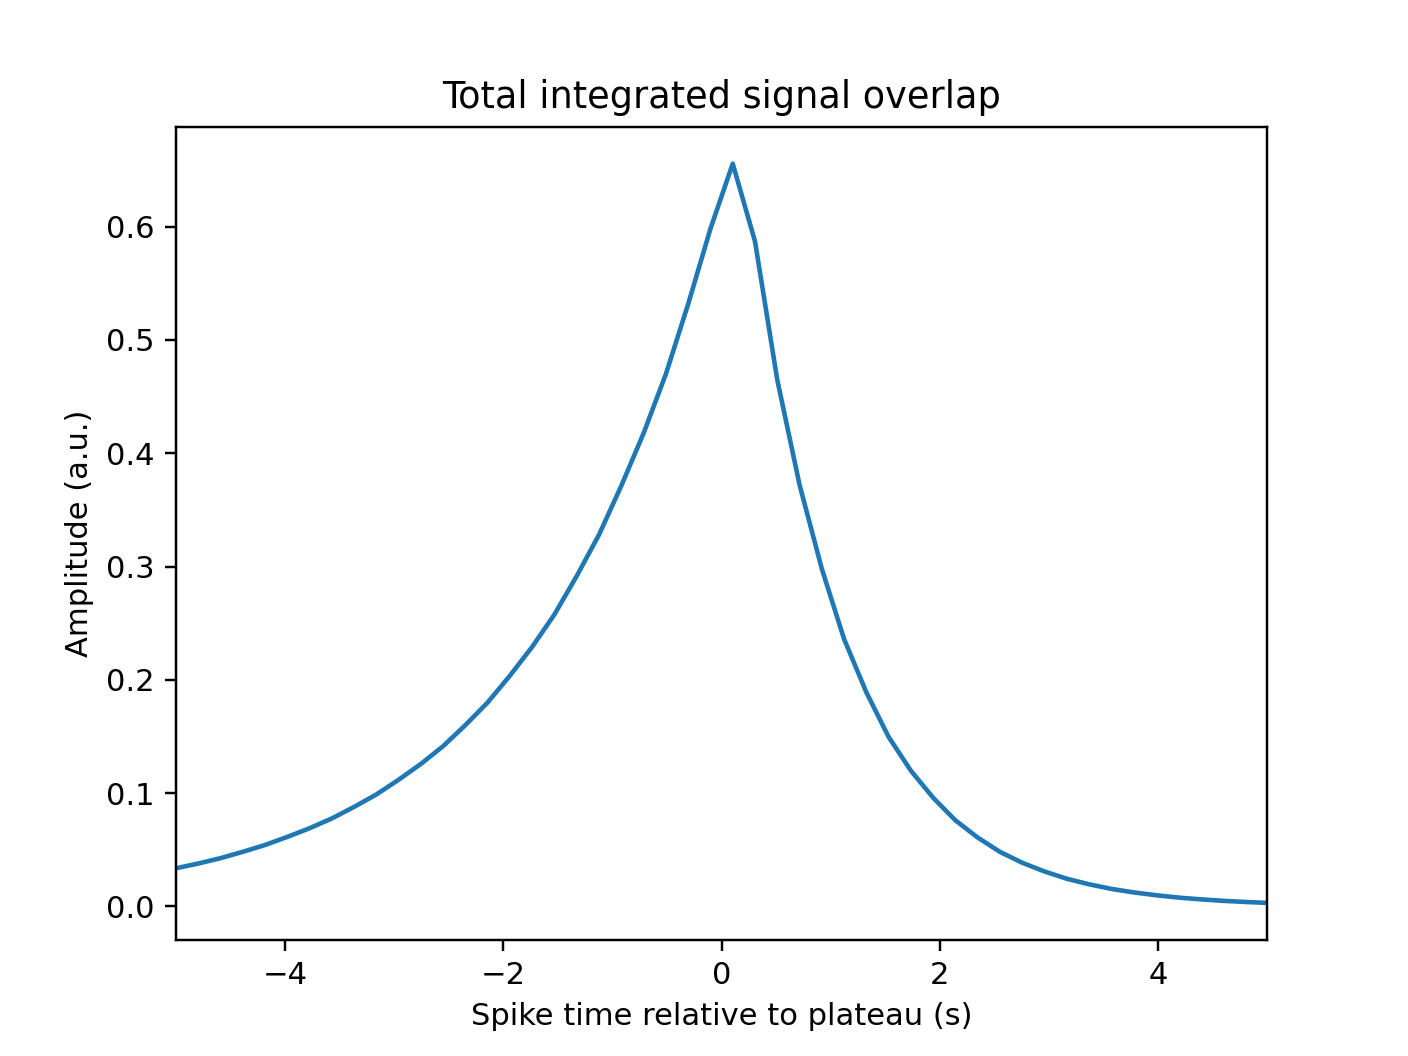

Text(0.5, 1.0, 'Total integrated signal overlap')

In [86]:
dt = t[1] - t[0]
area_ET_IS = np.trapz(ET_IS, dx=dt)
plt.figure()
plt.plot(input_locs, area_ET_IS)
plt.xlabel('Spike time relative to plateau (s)')
plt.ylabel('Amplitude (a.u.)')
plt.xlim((-5., 5.))
plt.title('Total integrated signal overlap')

In [87]:
def scaled_single_sigmoid(th, peak, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    return lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (xi - th))) - start_val) + ylim[0]


def get_linear_dW(dt, ET_IS, w, learning_rate, dep_ratio, max_weight):
    w0 = w / max_weight
    dWdt = learning_rate * ((1. - w0[:,None]) * ET_IS - dep_ratio * w0[:,None] * ET_IS)
    dW = np.trapz(dWdt, dx=dt)
    dW = np.maximum(-w0, np.minimum(1. - w0, dW))
    dW *= max_weight
    return dW


def get_linear_W_eq(dt, ET_IS, learning_rate, dep_ratio, max_weight):
    W_eq = np.ones(ET_IS.shape[0])
    W_eq *= 1. / (1. + dep_ratio) * max_weight
    return W_eq


def get_lin_pot_sig_dep_dW(dt, ET_IS, w, dep_f, learning_rate, dep_ratio, max_weight):
    w0 = w / max_weight
    dWdt = learning_rate * ((1. - w0[:,None]) * ET_IS - dep_ratio * w0[:,None] * dep_f(ET_IS))
    dW = np.trapz(dWdt, dx=dt)
    dW = np.maximum(-w0, np.minimum(1. - w0, dW))
    dW *= max_weight
    return dW


def get_lin_pot_sig_dep_W_eq(dt, ET_IS, dep_f, learning_rate, dep_ratio, max_weight):
    W_eq = np.empty(ET_IS.shape[0])
    W_eq[:] = np.nan
    numer = np.trapz(ET_IS, dx=dt)
    denom = np.trapz(ET_IS + dep_ratio * dep_f(ET_IS), dx=dt)
    indexes = np.where(denom >= 0.0005)
    W_eq[indexes] = numer[indexes] / denom[indexes] * max_weight
    return W_eq


def get_sig_dW(dt, ET_IS, w, pot_f, dep_f, learning_rate, dep_ratio, max_weight):
    w0 = w / max_weight
    dWdt = learning_rate * ((1. - w0[:,None]) * pot_f(ET_IS) - dep_ratio * w0[:,None] * dep_f(ET_IS))
    dW = np.trapz(dWdt, dx=dt)
    dW = np.maximum(-w0, np.minimum(1. - w0, dW))
    dW *= max_weight
    return dW


def get_sig_W_eq(dt, ET_IS, pot_f, dep_f, learning_rate, dep_ratio, max_weight):
    W_eq = np.empty(ET_IS.shape[0])
    W_eq[:] = np.nan
    numer = np.trapz(pot_f(ET_IS), dx=dt)
    denom = np.trapz(pot_f(ET_IS) + dep_ratio * dep_f(ET_IS), dx=dt)
    indexes = np.where(denom >= 0.0005)
    W_eq[indexes] = numer[indexes] / denom[indexes] * max_weight
    return W_eq

<IPython.core.display.Javascript object>


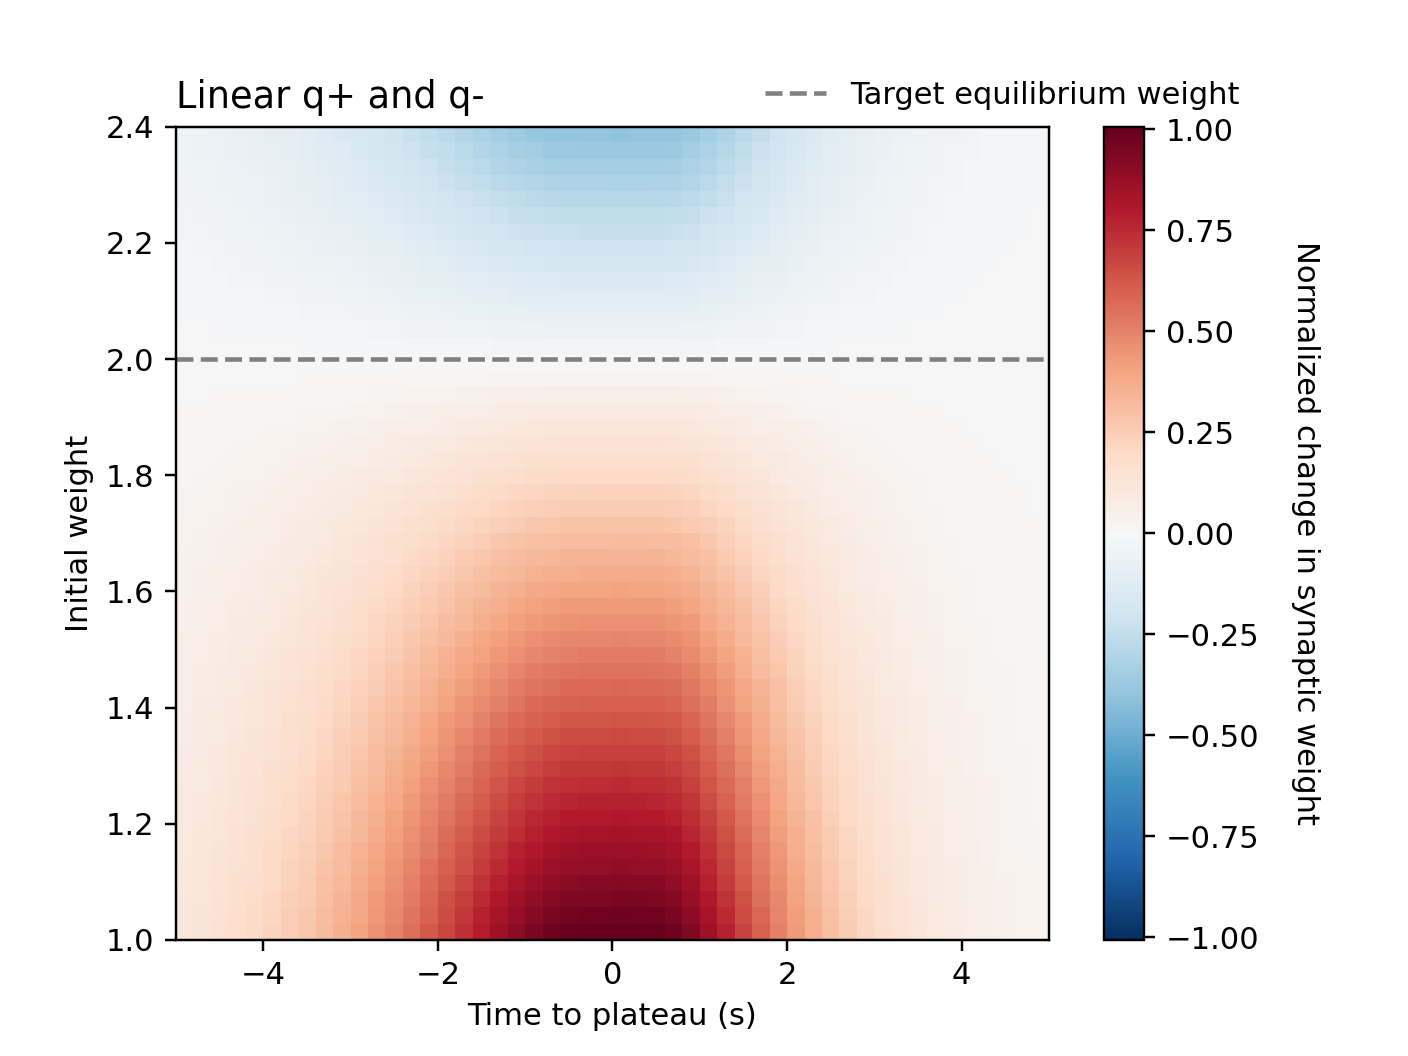

Text(0, 0.5, 'Initial weight')

In [126]:
lin_learning_rate = 1.2
lin_dep_ratio = 0.5
lin_max_weight = 3.
linear_dW_params = [lin_learning_rate, lin_dep_ratio, lin_max_weight]
tau_ET = 1.5 # 1.7
tau_IS = 1. # 0.9

example_pre = pre_activity[0,:]
plateau = np.zeros_like(t)
plateau_indexes = np.where((t >= 0.) & (t < 0.3))[0]
plateau[plateau_indexes] = 1.

filter_ET = np.exp(-t/tau_ET)
filter_ET /= np.sum(filter_ET)
this_ET = np.convolve(test, filter_ET)[:len(t)]
ET_norm_factor = np.max(this_ET)
this_ET /= ET_norm_factor

filter_IS = np.exp(-t/tau_IS)
filter_IS /= np.sum(filter_IS)
IS = np.convolve(plateau, filter_IS)[:len(t)]
IS /= np.max(IS)

ET = np.empty_like(pre_activity)
for i in range(input_dim):
    ET[i,:] = np.convolve(pre_activity[i,:], filter_ET)[:len(t)] / ET_norm_factor

ET_IS = ET * IS

linear_W_eq = get_linear_W_eq(dt, ET_IS, *linear_dW_params)
linear_dW = np.empty((input_dim, input_dim))
for i, w in enumerate(np.linspace(1., 2.4, input_dim)):
    initial_W = np.ones_like(input_locs) * w
    current_W = np.copy(initial_W)
    for j in range(3):
        this_lin_dW = get_linear_dW(dt, ET_IS, current_W, *linear_dW_params)
        current_W += this_lin_dW
    linear_dW[i,:] = np.subtract(current_W, initial_W)    
    
vmax = max(np.abs(np.max(linear_dW)), np.abs(np.min(linear_dW)))
fig = plt.figure()
plt.imshow(linear_dW[::-1,:], extent=(-5., 5., 1., 2.4), aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
cbar = plt.colorbar()
cbar.set_label('Normalized change in synaptic weight', rotation=270., labelpad=20)
plt.plot(input_locs, linear_W_eq, '--', c='grey', label='Target equilibrium weight')
plt.legend(frameon=False, bbox_to_anchor=(1.25, 1.09))
plt.title('Linear q+ and q-', loc='left')
plt.xlabel('Time to plateau (s)')
plt.ylabel('Initial weight')

<IPython.core.display.Javascript object>


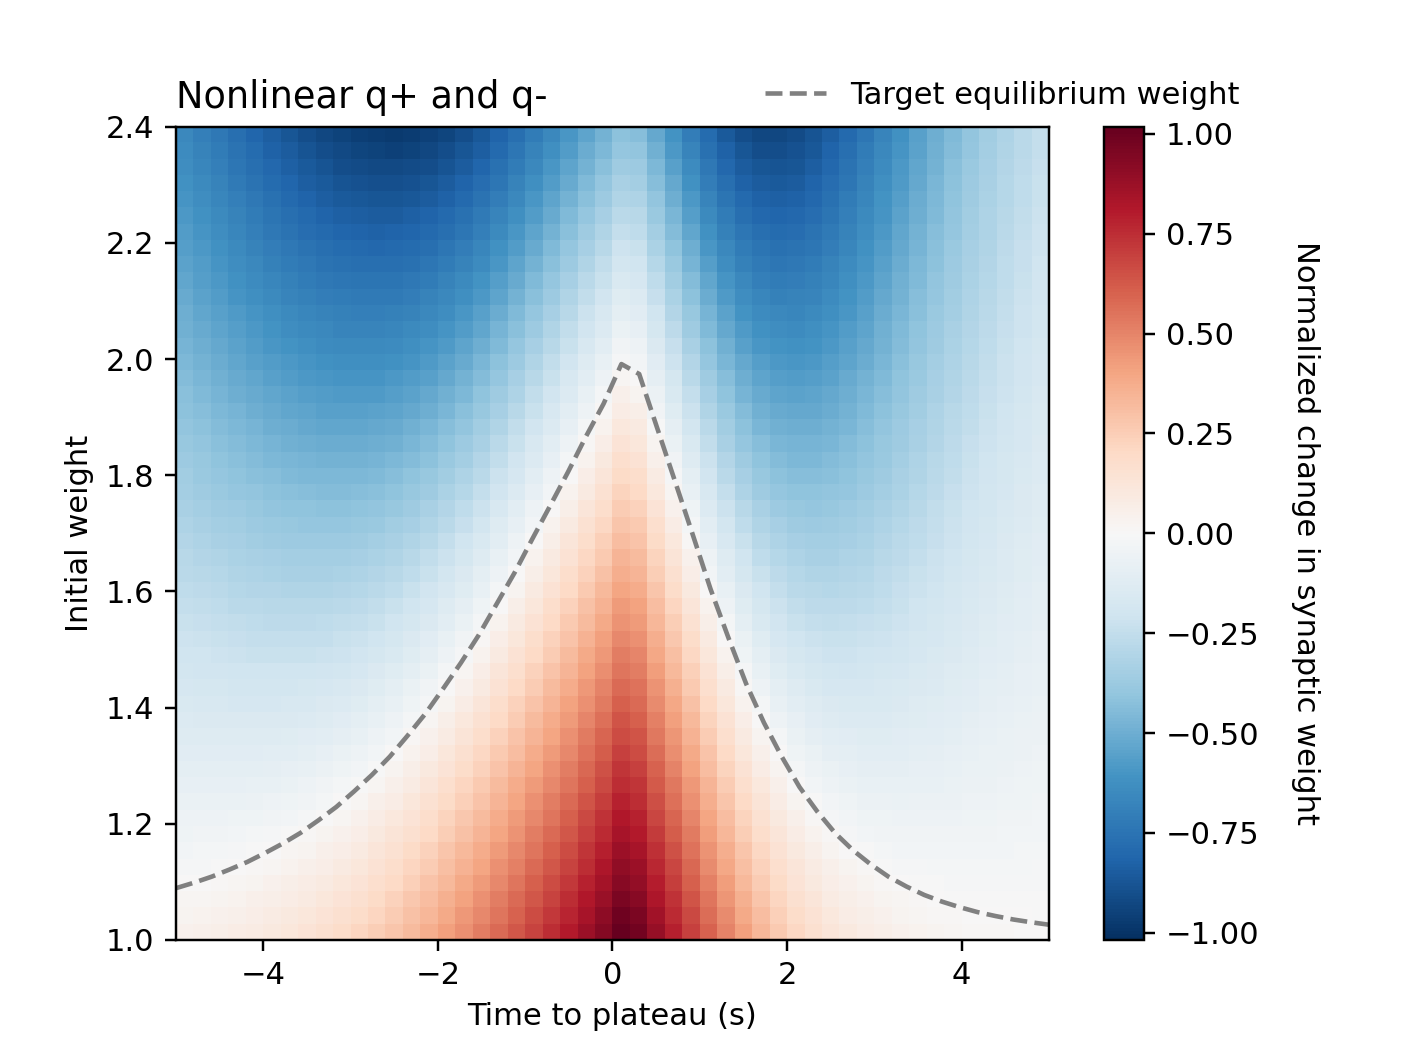

(1.0, 2.4)

In [125]:
sig_learning_rate = 0.7
sig_dep_ratio = 0.43
sig_max_weight = 4.
sig_dep_th = 0.01
sig_dep_width = 0.25
sig_pot_th = 0.5
sig_pot_width = 0.5
sig_dW_params = [sig_learning_rate, sig_dep_ratio, sig_max_weight]
sig_dep_f = scaled_single_sigmoid(sig_dep_th, sig_dep_th + sig_dep_width)
sig_pot_f = scaled_single_sigmoid(sig_pot_th, sig_pot_th + sig_pot_width)
tau_ET = 2.5 # 1.7
tau_IS = 1.5 # 0.9

example_pre = pre_activity[0,:]
plateau = np.zeros_like(t)
plateau_indexes = np.where((t >= 0.) & (t < 0.3))[0]
plateau[plateau_indexes] = 1.

filter_ET = np.exp(-t/tau_ET)
filter_ET /= np.sum(filter_ET)
this_ET = np.convolve(test, filter_ET)[:len(t)]
ET_norm_factor = np.max(this_ET)
this_ET /= ET_norm_factor

filter_IS = np.exp(-t/tau_IS)
filter_IS /= np.sum(filter_IS)
IS = np.convolve(plateau, filter_IS)[:len(t)]
IS /= np.max(IS)

ET = np.empty_like(pre_activity)
for i in range(input_dim):
    ET[i,:] = np.convolve(pre_activity[i,:], filter_ET)[:len(t)] / ET_norm_factor

ET_IS = ET * IS

sig_W_eq = get_sig_W_eq(dt, ET_IS, sig_pot_f, sig_dep_f, *sig_dW_params)
sig_dW = np.empty((input_dim, input_dim))
for i, w in enumerate(np.linspace(1., 2.4, input_dim)):
    initial_W = np.ones_like(input_locs) * w
    current_W = np.copy(initial_W)
    for j in range(3):
        this_sig_dW = get_sig_dW(dt, ET_IS, current_W, sig_pot_f, sig_dep_f, *sig_dW_params)
        current_W += this_sig_dW
    sig_dW[i,:] = np.subtract(current_W, initial_W)
    
vmax = max(np.abs(np.max(sig_dW)), np.abs(np.min(sig_dW)))
plt.figure()
plt.imshow(sig_dW[::-1,:], extent=(-5., 5., 1., 2.4), aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
cbar = plt.colorbar()
cbar.set_label('Normalized change in synaptic weight', rotation=270., labelpad=20)
plt.plot(input_locs, sig_W_eq, '--', c='grey', label='Target equilibrium weight')
plt.legend(frameon=False, bbox_to_anchor=(1.25, 1.09))
plt.title('Nonlinear q+ and q-', loc='left')
plt.xlabel('Time to plateau (s)')
plt.ylabel('Initial weight')
plt.ylim(1., 2.4)

<IPython.core.display.Javascript object>


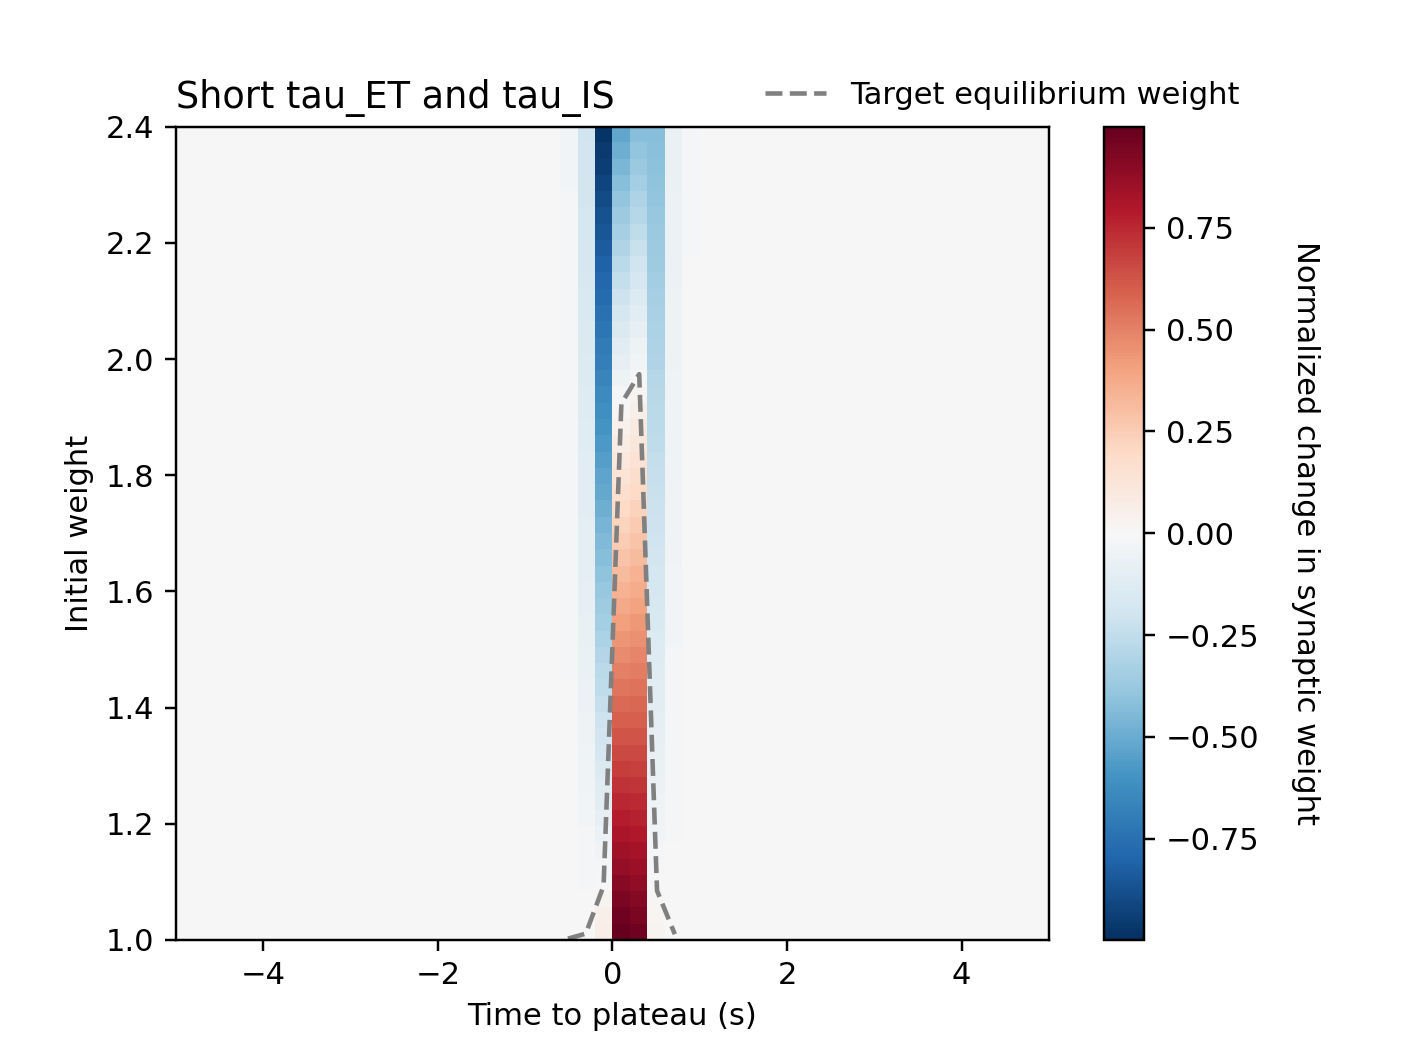

(1.0, 2.4)

In [124]:
sig_learning_rate = 9.
sig_dep_ratio = 0.43
sig_max_weight = 4.
sig_dep_th = 0.01
sig_dep_width = 0.25
sig_pot_th = 0.5
sig_pot_width = 0.5
sig_dW_params = [sig_learning_rate, sig_dep_ratio, sig_max_weight]
sig_dep_f = scaled_single_sigmoid(sig_dep_th, sig_dep_th + sig_dep_width)
sig_pot_f = scaled_single_sigmoid(sig_pot_th, sig_pot_th + sig_pot_width)
tau_ET = 0.1 # 1.7
tau_IS = 0.1 # 0.9

example_pre = pre_activity[0,:]
plateau = np.zeros_like(t)
plateau_indexes = np.where((t >= 0.) & (t < 0.3))[0]
plateau[plateau_indexes] = 1.

filter_ET = np.exp(-t/tau_ET)
filter_ET /= np.sum(filter_ET)
this_ET = np.convolve(test, filter_ET)[:len(t)]
ET_norm_factor = np.max(this_ET)
this_ET /= ET_norm_factor

filter_IS = np.exp(-t/tau_IS)
filter_IS /= np.sum(filter_IS)
IS = np.convolve(plateau, filter_IS)[:len(t)]
IS /= np.max(IS)

ET = np.empty_like(pre_activity)
for i in range(input_dim):
    ET[i,:] = np.convolve(pre_activity[i,:], filter_ET)[:len(t)] / ET_norm_factor

ET_IS = ET * IS

sig_W_eq = get_sig_W_eq(dt, ET_IS, sig_pot_f, sig_dep_f, *sig_dW_params)
sig_dW = np.empty((input_dim, input_dim))
for i, w in enumerate(np.linspace(1., 2.4, input_dim)):
    initial_W = np.ones_like(input_locs) * w
    current_W = np.copy(initial_W)
    for j in range(3):
        this_sig_dW = get_sig_dW(dt, ET_IS, current_W, sig_pot_f, sig_dep_f, *sig_dW_params)
        current_W += this_sig_dW
    sig_dW[i,:] = np.subtract(current_W, initial_W)
    
vmax = max(np.abs(np.max(sig_dW)), np.abs(np.min(sig_dW)))
plt.figure()
plt.imshow(sig_dW[::-1,:], extent=(-5., 5., 1., 2.4), aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
cbar = plt.colorbar()
cbar.set_label('Normalized change in synaptic weight', rotation=270., labelpad=20)
plt.plot(input_locs, sig_W_eq, '--', c='grey', label='Target equilibrium weight')
plt.legend(frameon=False, bbox_to_anchor=(1.25, 1.09))
plt.title('Short tau_ET and tau_IS', loc='left')
plt.xlabel('Time to plateau (s)')
plt.ylabel('Initial weight')
plt.ylim(1., 2.4)